In [6]:
import pandas as pd, numpy as np
import matplotlib, seaborn as sns
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams['figure.constrained_layout.use'] = True


In [2]:
mydateparser = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
btc_series = pd.read_excel('Data/BTC_closing.xlsx',squeeze=True, parse_dates=[0], index_col=0, date_parser=mydateparser)
btc_df = pd.DataFrame(btc_series)

In [3]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(btc_series)
print('ADF-Statistic: %.4f' %adf_result[0], '\n', adf_result[4])

ADF-Statistic: -1.8142 
 {'1%': -3.4333712566259007, '5%': -2.8628746849930136, '10%': -2.567480519733324}


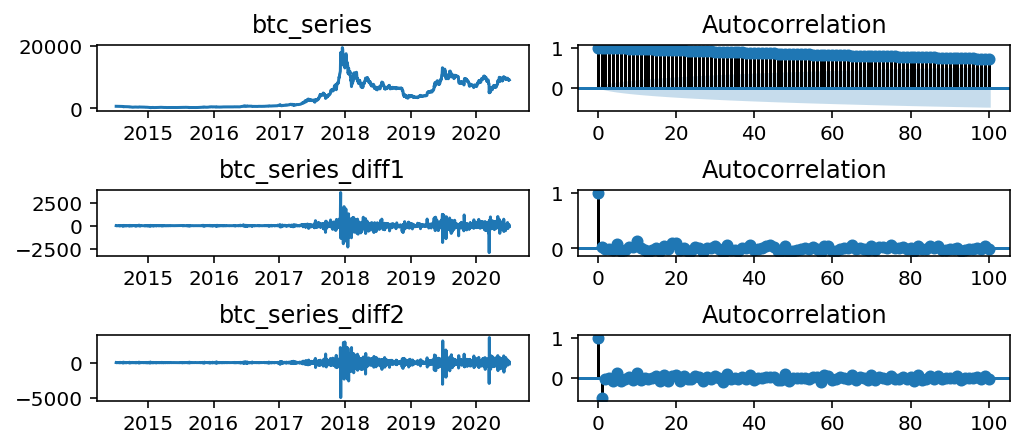

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
#Original series
fig, axes = plt.subplots(3,2)
axes[0,0].plot(btc_series); axes[0,0].set_title('btc_series')
plot_acf(btc_series, ax=axes[0,1], lags=100)

#1st difference
axes[1,0].plot(btc_series.diff().dropna()); axes[1,0].set_title('btc_series_diff1')
plot_acf((btc_series.diff().dropna()), ax=axes[1,1], lags=100)

#2nd difference
axes[2,0].plot(btc_series.diff().diff().dropna()); axes[2,0].set_title('btc_series_diff2')
plot_acf(btc_series.diff().diff().dropna(), ax=axes[2,1], lags=100)

In [13]:
from pmdarima.arima.utils import ndiffs
print('ADF_order:\t', ndiffs(btc_series, test='adf'))
print('PP_order:\t', ndiffs(btc_series, test='pp'))
print('KPSS_order:\t', ndiffs(btc_series, test='kpss'))

ADF_order:	 1
PP_order:	 1
KPSS_order:	 1


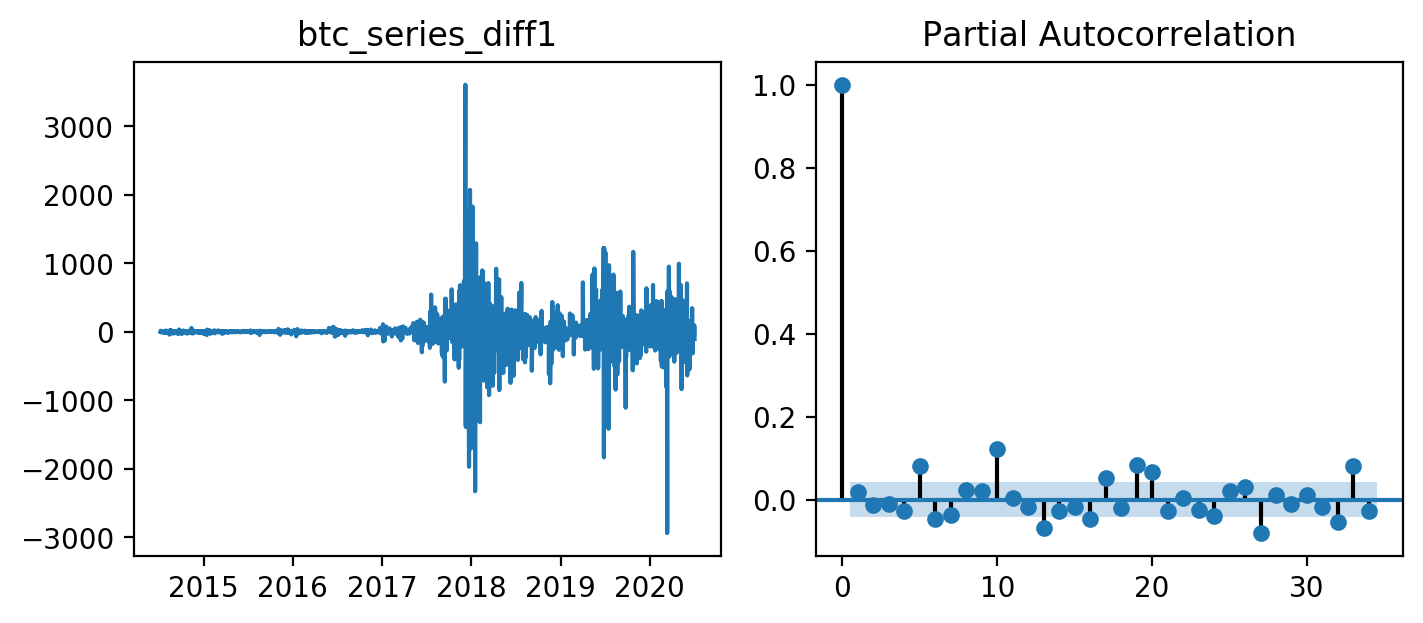

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_series.diff().dropna()); axes[0].set_title('btc_series_diff1')
plot_pacf(btc_series.diff().dropna(), ax=axes[1])

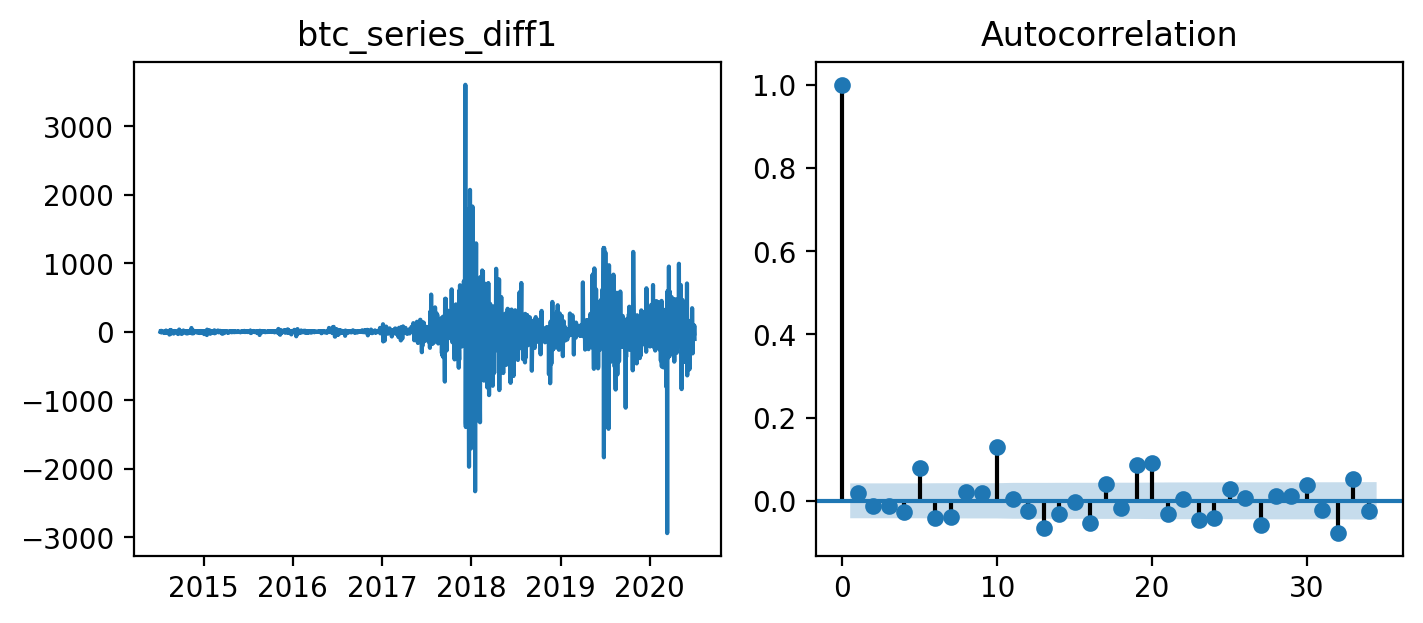

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1,2)
axes[0].plot(btc_series.diff().dropna()); axes[0].set_title('btc_series_diff1')
plot_acf(btc_series.diff().dropna(), ax=axes[1])

In [28]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(btc_series, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\joche\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\joche\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2187
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -15431.964
Method:                       css-mle   S.D. of innovations            280.700
Date:                Mon, 06 Jul 2020   AIC                          30871.929
Time:                        18:02:38   BIC                          30894.690
Sample:                    07-08-2014   HQIC                         30880.249
                         - 07-02-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.8914      6.088      0.639      0.523      -8.041      15.824
ar.L1.D.Close    -0.7298      0.155     -4.694      0.000      -1.035      -0.425
ma.L1.D.Close     0.7545      0.149     